In [93]:
import os
import numpy as np

import scipy.linalg 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from read_files import *
from my_interpolate import *
from scipy import spatial, optimize
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

In [94]:
DATASET = 'HAND'

def get_centroids(points):
    """ obtain centroid of LV cardiac dataset which consists of two
    circles each containing 33 points """
    c1 = np.mean(points[:33],axis = 0)
    c2 = np.mean(points[33:],axis = 0) 
    return c1,c2

def unmake_1d(hand):
    return np.array([ [hand[i], hand[i+56]] for i in range(0,hand.shape[0]//2)])
    #return np.vstack([hand[range(0, len(hand), 2)], hand[range(0, len(hand), 2)]])

def make_1d(hand):
    return np.concatenate((hand[:,0],hand[:,1])).reshape(-1)
    #return hand.flatten()

def unmake_xy(hand):
    return np.vstack([hand[range(0, len(hand), 2)], hand[range(1, len(hand), 2)]]).T

def make_xy(hand) :
    return hand.flatten()


def showImg(filename,show = False):
    plt.imshow(mpimg.imread(filename))
    plt.axis('off')
    if show:
        plt.show()

    
def showPoints(points,W=256,H=256, show = False,color = 'white'):
    points = np.array(points)
    plt.scatter(points[:,0]*W,points[:,1]*H,color=color,s = 1) 
    if show:
        plt.show()

def showSegImg(imgpath,points,W = None,H = None):
    if W is  None:
        W,H = getImageWH(imgpath)
    showImg(imgpath)
    if DATASET == 'HAND':
        pass
    else:

        showInterp(interp(points[:33]),W,H)
        showInterp(interp(points[33:]),W,H)
    showPoints(points,W,H,True)


def showCentroids(centroids,W=256,H=256):
    plt.scatter(centroids[:,0,0]*W,centroids[:,0,1]*H,marker = '4',color = 'black')
    plt.scatter(centroids[:,1,0]*W,centroids[:,1,1]*H,marker = '4',color = 'black')
    plt.axis('off')

def showPCAModes(mean_centre, mode ,title = None):
    mean_center_in = mean_centre.reshape(66,-1)[:33]
    mean_center_out = mean_centre.reshape(66,-1)[33:]

    ax1 = plt.subplot(1,2,1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in + mode.reshape(66,-1)[:33]),marker = 'b')
    showInterp(interp(mean_center_out + mode.reshape(66,-1)[:33]),marker = 'b')

    plt.subplot(1,2,2, sharex = ax1,sharey = ax1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in - mode.reshape(66,-1)[33:]),marker = 'g')
    showInterp(interp(mean_center_out - mode.reshape(66,-1)[33:]),marker = 'g')
    if title:
        plt.suptitle(title)
    
    plt.show()
    
def procrustes_hand(hands):
    np.testing.assert_equal(make_xy(unmake_xy(hands[0])),hands[0])
    normalized_hands = hands
    old_normalized_hands = hands
    
    #fig = plt.figure()
    #for hand in normalized_hands:
    #    showInterp(interp(unmake_1d(hand)))
    #plt.title('Before Procrustes Alignment')
    #plt.show()
    
    for count in range(5):
        mean_hand = np.mean(normalized_hands,axis = 0)
        for i,hand in enumerate(hands):
            _, mtx, disparity = scipy.spatial.procrustes(unmake_xy(mean_hand),
                                                         unmake_xy(hand))
            normalized_hands[i] = make_xy(mtx)

        
    #fig = plt.figure()
    #for hand in normalized_hands:
    #    showInterp(interp(unmake_1d(hand)))
    #plt.title('After Procrustes Alignment')
    #plt.show()
    
    return normalized_hands

def plot_hand(Samples, points=[]) :
    for Sample in Samples :
        plt.plot(Sample[:, 0], Sample[:, 1])
        if points : 
            plt.scatter(Sample[points, 0], Sample[points, 1])
    plt.show()

In [95]:
filepath = './ssm_datasets/hand/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T

Data = []
for i in range(hands.shape[0]) :
    v =  unmake_1d(hands[i])
    Shape = np.array(interp(v, False)).T
    Data.append(make_xy(Shape))

Data = np.array(Data)

#showSegImg(os.path.join(filepath,'0000.jpg'),unmake_1d(hands[0]),600,600)

normalized_hands = procrustes_hand(np.array(Data))
normalized_hands /= np.max(normalized_hands)
mean_hand = np.mean(normalized_hands, axis=0)

normalized_hands -= mean_hand
mean_hand.shape, normalized_hands.shape

((300,), (40, 300))

In [96]:
Train_data, Test_data = normalized_hands[:-3, :], normalized_hands[-3:, :]
Train_data.shape, Test_data.shape, np.std(Train_data)

((37, 300), (3, 300), 0.052821212423349695)

In [97]:
def cov_function(Points, l, n):
    kernel = 1.0 * Matern(length_scale=l, nu=n)+ ConstantKernel()+ WhiteKernel(noise_level=0.001) 
    return kernel(Points)

In [98]:
def expe_cov(A, s, sigma) :
    return s*np.exp(-(A)/(sigma**2))

In [99]:
Mean_shape = unmake_xy(mean_hand)
Reduced_cov = np.zeros((len(mean_hand)//2, len(mean_hand)//2))

s = 2
sigma = 0.05
Reduced_cov = expe_cov(spatial.distance.cdist(Mean_shape, Mean_shape), s, sigma)

In [100]:
Cov_matrix = np.zeros((2*Reduced_cov.shape[0], 2*Reduced_cov.shape[0]))

for i in range(Reduced_cov.shape[0]):
    for j in range(Reduced_cov.shape[0]) :
        Cov_matrix[2*i:2*i+2, 2*j:2*j+2] = Reduced_cov[i, j]*np.eye(2)

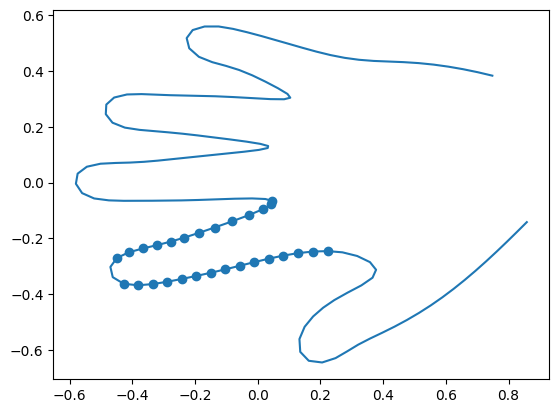

In [101]:
Missing_Region = list(range(33, 48))+list(range(50, 63))

plot_hand([Mean_shape], Missing_Region)

In [102]:
Indexes = np.ones(mean_hand.shape)
for i in range(len(Missing_Region)) :
    #Indexes.append(2*Missing_Region[i])
    #Indexes.append(2*Missing_Region[i]+1)
    Indexes[2*Missing_Region[i]], Indexes[2*Missing_Region[i]+1] = 0, 0

Indexes = Indexes.astype(int)

In [103]:
Sample_id = 4
observed_points = Train_data[Sample_id, Indexes==1]

Kxy = Cov_matrix[Indexes==0, :][:, Indexes==1]
Kyy = Cov_matrix[Indexes==1, :][:, Indexes==1]

Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

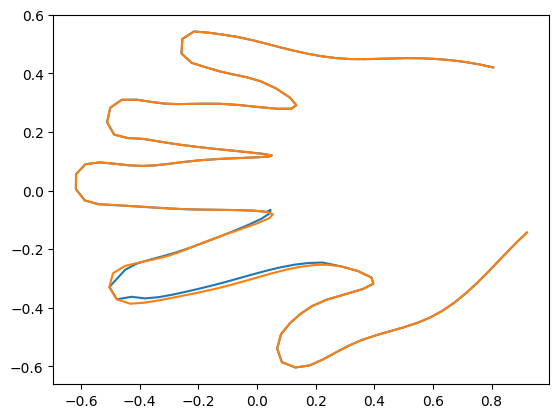

In [104]:
Zipped_data = np.zeros(mean_hand.shape)
Zipped_data[Indexes==0] = Predicted_points
Zipped_data[Indexes==1] = observed_points
Zipped_data += mean_hand

plot_hand([unmake_xy(Zipped_data), unmake_xy(Train_data[Sample_id]+mean_hand)])


In [105]:
def Cost(params):
    l = params[0]
    n = params[1]

    Reduced_cov = np.zeros((Mean_shape.shape[0], Mean_shape.shape[0]))
    for i in range(len(Train_data)) :
        Reduced_cov += cov_function(unmake_xy(Train_data[i, :]), l, n)
        #Reduced_cov += expe_cov(spatial.distance.cdist(unmake_xy(Train_data[i, :]), unmake_xy(Train_data[i, :])), s, sigma)

    Reduced_cov /= len(Train_data)

    Cov_matrix = np.zeros((2*Reduced_cov.shape[0], 2*Reduced_cov.shape[0]))

    for i in range(Reduced_cov.shape[0]):
        for j in range(Reduced_cov.shape[0]) :
            Cov_matrix[2*i:2*i+2, 2*j:2*j+2] = Reduced_cov[i, j]*np.eye(2)

    #Noised_train_data = Train_data + np.random.normal(0, 0.001, Train_data.shape)
    Noised_test_data = Test_data + np.random.normal(0, 0.001, Test_data.shape)
    C = 0
    for i in range(len(Test_data)) :
        
        Sample_id = i
        observed_points = Noised_test_data[Sample_id, Indexes==1]

        Kxy = Cov_matrix[Indexes==0, :][:, Indexes==1]
        Kyy = Cov_matrix[Indexes==1, :][:, Indexes==1]

        Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

        Zipped_data = np.zeros(mean_hand.shape)
        Zipped_data[Indexes==0] = Predicted_points
        Zipped_data[Indexes==1] = observed_points
        #Zipped_data += mean_hand

        C +=  np.linalg.norm(Zipped_data-Test_data[Sample_id])
        #plot_hand([unmake_xy(Zipped_data), unmake_xy(Test_data[Sample_id]+mean_hand)])
    return C

In [106]:
Lenght_range = np.linspace(0.1, 4, 4)
Mu_range = np.array([0.5, 1.5, 2.5, 3.5, 4.5])

In [107]:
"""C = float('inf')
p = [0, 0]
for l in Lenght_range :
    for n in Mu_range :
        params0 = [l, n]
        print(params0)
        try : 
            opt = optimize.minimize(Cost, params0)
            if opt.fun<C :
                C = opt.fun 
                p[0], p[1] = l, n
        except :
            pass"""

"C = float('inf')\np = [0, 0]\nfor l in Lenght_range :\n    for n in Mu_range :\n        params0 = [l, n]\n        print(params0)\n        try : \n            opt = optimize.minimize(Cost, params0)\n            if opt.fun<C :\n                C = opt.fun \n                p[0], p[1] = l, n\n        except :\n            pass"

In [108]:
p = [3, 1.5]

#LOOK FROM HERE#

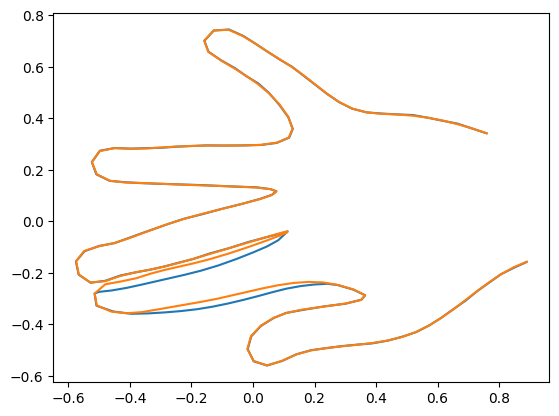

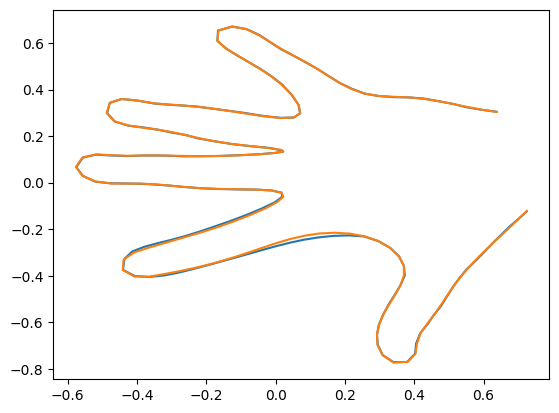

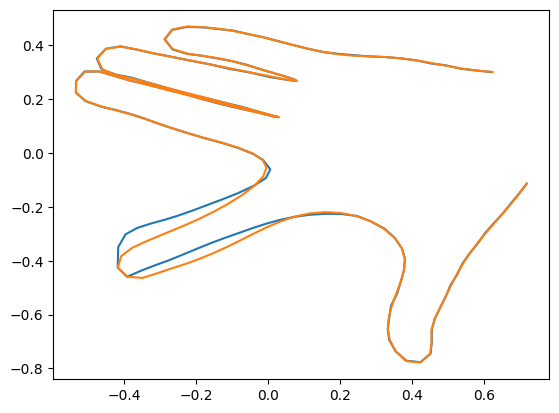

In [109]:
s = p[0]
sigma = p[1]
#Reduced_cov = expe_cov(spatial.distance.cdist(Mean_shape, Mean_shape), s, sigma)

l = 3
n = 0.5

Reduced_cov = np.zeros((Mean_shape.shape[0], Mean_shape.shape[0]))
for i in range(len(Train_data)) :
    Reduced_cov += cov_function(unmake_xy(Train_data[i, :]), l, n)
    #Reduced_cov += expe_cov(spatial.distance.cdist(unmake_xy(Train_data[i, :]), unmake_xy(Train_data[i, :])), s, sigma)

Reduced_cov /= len(Train_data)

Cov_matrix = np.zeros((2*Reduced_cov.shape[0], 2*Reduced_cov.shape[0]))

for i in range(Reduced_cov.shape[0]):
    for j in range(Reduced_cov.shape[0]) :
        Cov_matrix[2*i:2*i+2, 2*j:2*j+2] = Reduced_cov[i, j]*np.eye(2)

Noised_train_data = Train_data + np.random.normal(0, 0.001, Train_data.shape)
Noised_test_data = Test_data + np.random.normal(0, 0.001, Test_data.shape)
for i in range(len(Test_data)) :
    
    Sample_id = i
    observed_points = Noised_test_data[Sample_id, Indexes==1]

    Kxy = Cov_matrix[Indexes==0, :][:, Indexes==1]
    Kyy = Cov_matrix[Indexes==1, :][:, Indexes==1]

    Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

    Zipped_data = np.zeros(mean_hand.shape)
    Zipped_data[Indexes==0] = Predicted_points
    Zipped_data[Indexes==1] = observed_points
    Zipped_data += mean_hand

    plot_hand([unmake_xy(Zipped_data), unmake_xy(Test_data[Sample_id]+mean_hand)])

In [110]:
class GPregressor :
    def __init__(self, Input_dim, Nb_points, kernel):
        self.dim_i = Input_dim
        self.Nb = Nb_points
        self.kernel = kernel
        self.Cov_mat = []

    def unmake_xy(hand):
        return np.vstack([hand[range(0, len(hand), 2)], hand[range(1, len(hand), 2)]]).T

    def make_xy(hand) :
        return hand.flatten()

    def Cov_func(self, Points):
        #kernel = 1.0 * Matern(length_scale=l, nu=n)+ ConstantKernel()+ WhiteKernel(noise_level=0.001)
        return self.kernel(Points)

    def fit(self, Training_shapes) :

        Reduced_cov = np.zeros((self.Nb, self.Nb))
        for i in range(len(Training_shapes)) :
            Reduced_cov += self.Cov_func(unmake_xy(Training_shapes[i, :]))

        Reduced_cov /= len(Training_shapes)

        for i in range(self.Nb):
            for j in range(self.Nb) :
                Cov_matrix[self.dim_i*i:self.dim_i*(i+1), self.dim_i*j:self.dim_i*(j+1)] = Reduced_cov[i, j]*np.eye(self.dim_i)
        
        self.Cov_mat = Cov_matrix

    def predict(self, Incomplete_shape, Indexes) :

        observed_points = Incomplete_shape[Indexes==1]
        Kxy = self.Cov_mat[Indexes==0, :][:, Indexes==1]
        Kyy = self.Cov_mat[Indexes==1, :][:, Indexes==1]
        print(np.average(np.linalg.inv(Kyy)), np.average(Kxy), np.average(observed_points))

        Predicted_points = Kxy@np.linalg.inv(Kyy)@observed_points

        Zipped_data = np.zeros(Incomplete_shape.shape)
        Zipped_data[Indexes==0] = Predicted_points
        Zipped_data[Indexes==1] = observed_points

        return Zipped_data
    

        

3.3266008079042965e-05 0.5008179965647028 0.0030337749865515136


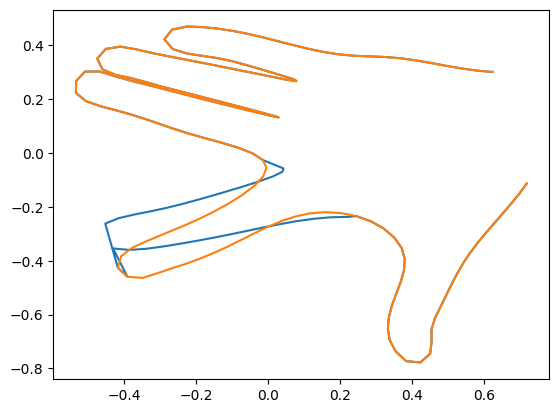

In [114]:
params = [3, 0.0001]
sigma = 0.001
My_kernel = 1.0 * Matern(length_scale=params[0], nu=params[1])+ ConstantKernel()+ WhiteKernel(noise_level=sigma)
GP = GPregressor(Input_dim=2, Nb_points=len(Mean_shape), kernel=My_kernel)
GP.fit(Train_data[:, :])

Test_shape = Test_data[2, :]
Predicted_shape = GP.predict(Test_shape, Indexes)
plot_hand([unmake_xy(Predicted_shape+mean_hand), unmake_xy(Test_shape+mean_hand)])

In [112]:
#print(GP.Cov_mat)

In [113]:
print(GP.Cov_mat)

[[2.000001   0.         1.99999005 ... 0.         1.99934988 0.        ]
 [0.         2.000001   0.         ... 1.99934609 0.         1.99934988]
 [1.99999005 0.         2.000001   ... 0.         1.99928512 0.        ]
 ...
 [0.         1.99934609 0.         ... 2.000001   0.         1.99999613]
 [1.99934988 0.         1.99928512 ... 0.         2.000001   0.        ]
 [0.         1.99934988 0.         ... 1.99999613 0.         2.000001  ]]
